# Horizontal stream function conservation

author, Wenrui Jiang 06/06/2022

This package currently only support velocity to be piecewise stationary in time. For a stable velocity field, the streakline will match the streamline of the field.

For 2D cases, this means conservation of stream function.

$$
\frac{d \Psi}{dt} = 0
$$

A strong test can be construct as following: **simulate the particles under an arbitrary stream function and compare the stream function before-and-after**. If the code is correct, the stream function defined at the starting position of a particle should match that defined at the final position.

In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
import xarray as xr
from matplotlib import cm, colors

import seaduck as sd

mpl.rcParams["figure.dpi"] = 300

warnings.filterwarnings("ignore")

## Loading data

For this test example, the stream function we are going to use is an award-winning eddie in the arbitrary/cute department. Let's load it.

In [2]:
file_path = pooch.retrieve(
    url="https://github.com/MaceKuailv/seaduck_sciserver_notebook/raw/master/diffused_duck.npy",
    known_hash="8968fc89a57a492879dff6b458ffa1e03bb533e82bd76ca5db8496182fa2c32f",
)

strmf = np.load(file_path)[::-1]
M, N = strmf.shape
M -= 1
N -= 1
x = np.linspace(-1, 1, N + 1)
y = np.linspace(-1, 1, M + 1)
xg, yg = np.meshgrid(x, y)

To show that I am not volkswagening you, I will plot the stream function.

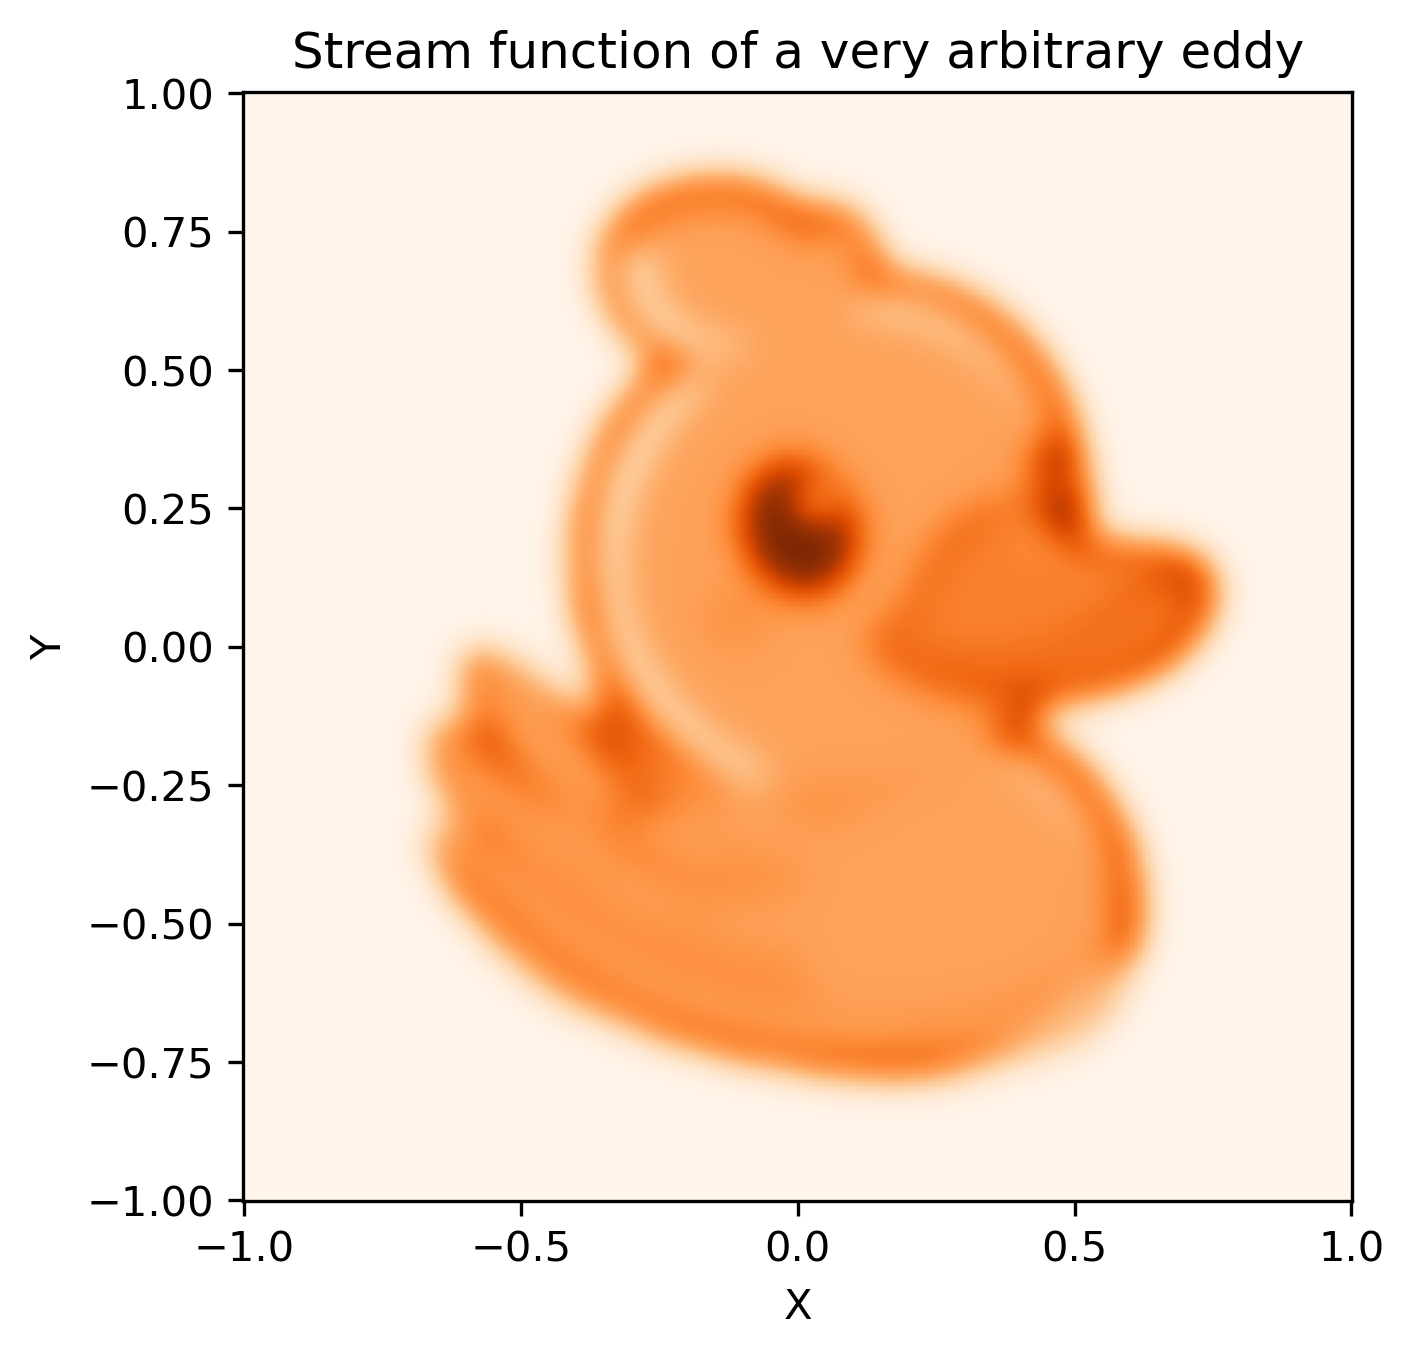

In [3]:
plt.pcolormesh(xg, yg, strmf, cmap="Oranges")
plt.gca().set_aspect("equal")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Stream function of a very arbitrary eddy")
plt.show()

**Fig.1** A stream function that is not particular in any senses.

Now we prepare create the grids needed and therefore the xarray dataset for the simulation.

In [4]:
xv = 0.5 * (xg[:, 1:] + xg[:, :-1])
yv = 0.5 * (yg[:, 1:] + yg[:, :-1])
xu = 0.5 * (xg[1:] + xg[:-1])
yu = 0.5 * (yg[1:] + yg[:-1])

xc = 0.5 * (xv[1:] + xv[:-1])
yc = 0.5 * (yv[1:] + yv[:-1])

In [5]:
u = np.diff(strmf, axis=0)
v = -np.diff(strmf, axis=1)

In [6]:
ds = xr.Dataset(
    coords=dict(
        XC=(["Y", "X"], xc),
        YC=(["Y", "X"], yc),
        XG=(["Yp1", "Xp1"], xg),
        YG=(["Yp1", "Xp1"], yg),
        rA=(["Y", "X"], np.ones_like(xc, float)),
    ),
    data_vars=dict(
        UVELMASS=(["Y", "Xp1"], u),
        VVELMASS=(["Yp1", "X"], v),
        streamfunc=(["Yp1", "Xp1"], strmf),
    ),
)
ds

<xarray.Dataset>
Dimensions:     (Y: 699, Xp1: 700, Yp1: 700, X: 699)
Coordinates:
    XC          (Y, X) float64 -0.9986 -0.9957 -0.9928 ... 0.9928 0.9957 0.9986
    YC          (Y, X) float64 -0.9986 -0.9986 -0.9986 ... 0.9986 0.9986 0.9986
    XG          (Yp1, Xp1) float64 -1.0 -0.9971 -0.9943 ... 0.9943 0.9971 1.0
    YG          (Yp1, Xp1) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 1.0 1.0 1.0 1.0
    rA          (Y, X) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Dimensions without coordinates: Y, Xp1, Yp1, X
Data variables:
    UVELMASS    (Y, Xp1) float64 0.0 0.0 0.0 0.0 ... -1.616e-78 -2.363e-83 0.0
    VVELMASS    (Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    streamfunc  (Yp1, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

## Prepare for the test

First, we create the `seaduck.OceData` object

In [7]:
tub = sd.OceData(ds)

Then, initialize the particle position.

In [8]:
num_particle = 8000
np.random.seed(99)
x = np.random.random(num_particle) * 1.6 - 0.8
y = np.random.random(num_particle) * 1.8 - 0.9

In [9]:
pt = sd.Particle(
    x=x, y=y, z=None, t=np.zeros_like(x), data=tub, wname=None, transport=True
)

Finally, we need a proper kernel for interpolating stream function. The natural definition for this case is to interpolate using the four closest corner points.

In [10]:
kkk = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

gknw = sd.KnW(kkk, vkernel="nearest", tkernel="nearest")

## The actual test

First we interpolate the streamfunction at the starting position.

In [11]:
before = pt.interpolate("streamfunc", gknw)

Now, simulate the particles forward for a decent amount of time.

In [12]:
steps = 15
stops, ps = pt.to_list_of_time(
    normal_stops=np.linspace(0, 2 * steps * N, steps), update_stops=[]
)

Now that, the particles are at a different position. Let's look at the stream functions again and compare.

In [13]:
after = ps[-1].interpolate("streamfunc", gknw)

In [14]:
is_it_close = np.allclose(after, before, atol=1e-7)
max_difference = np.max(np.abs(after - before))
print(f"Is the stream function conserved? {is_it_close}")
print(f"The maximum difference is {max_difference }")

Is the stream function is conserved? True
The maximum difference is 2.7226845861205717e-08


To put that in perspective: The stream function ranges from 0 to around 0.6. So this is a small difference!

## Unless you are not convinced

"Hey, you just used your own function to test another function. I didn't see anything under the hood. "
"Also, the stream function should be conserved along the **entire trajectory**. Not only the start and the end"

Well, here is a more visual way of proving my points.

I am going to plot the trajectory of all the particles, and color them using the **initial** stream function.

If the stream function is not conserved at any point, the color of the lines drawn (initial value of stream function) will not match that we plotted earlier (the actual value defined at that point).

In [15]:
lons = []
lats = []
for ppp in ps:
    lons.append(ppp.lon)
    lats.append(ppp.lat)
lons = np.array(lons)
lats = np.array(lats)

Using the same color scheme as the previous plot

In [16]:
norm = colors.Normalize(vmin=0.0, vmax=0.6, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Oranges)

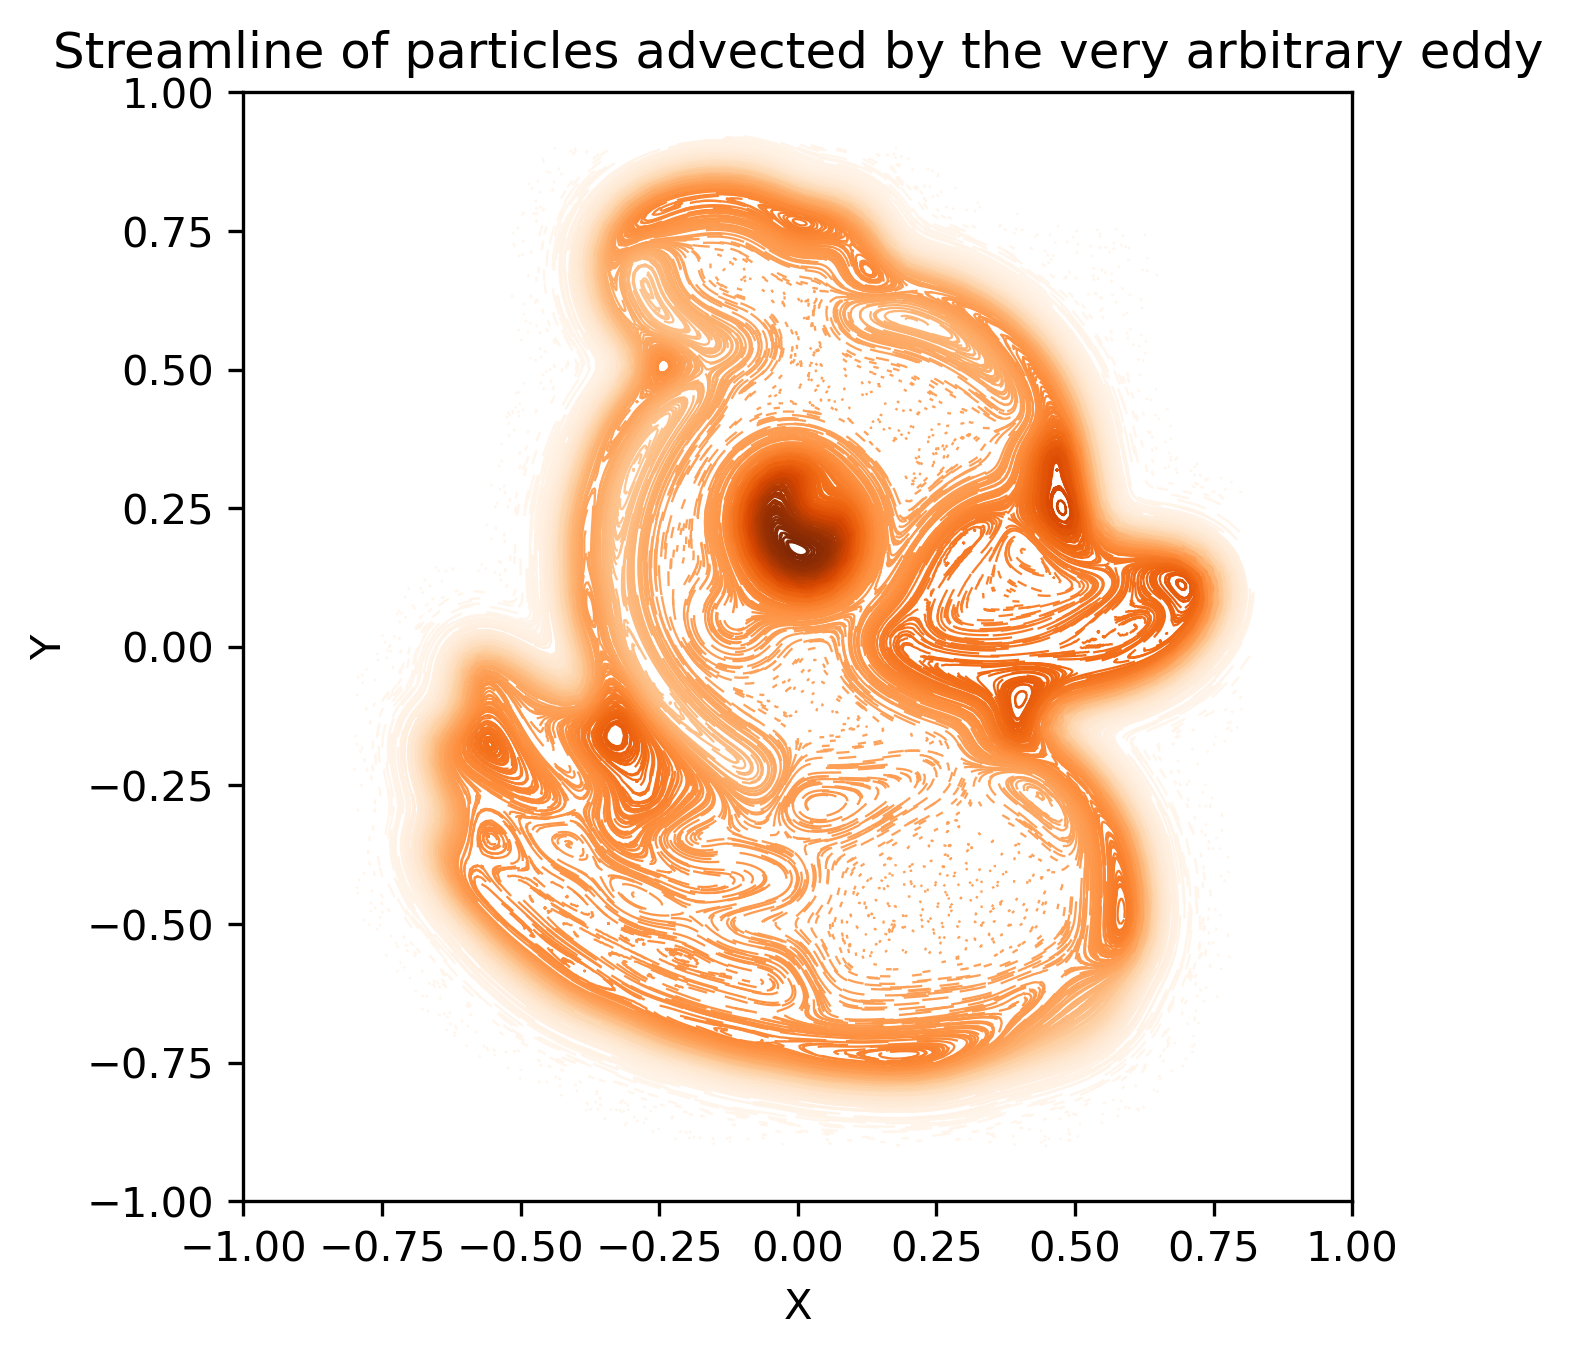

In [17]:
for i in range(len(x)):
    plt.plot(lons.T[i], lats.T[i], c=mapper.to_rgba(before[i]), lw=0.55)
plt.gca().set_aspect("equal")
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Streamline of particles advected by the very arbitrary eddy")
plt.show()

**Fig.1** The trajectories of particles advected by the very arbitrary eddy. The color denotes the initial value of stream function.